# Stochastic Computing

The goal of this part of the workshop is to explore a simple example 
of stochastic computing with spiking neurons.

<img src="images/stochastic_computing.png" style="width:50%"/>

## Step 0: Install Requirements



## Step 1: Neuron Model

In [49]:
import norse
import torch
import numpy as np
import os

from norse.torch.module import LIFRefracRecurrentCell
from norse.torch.functional.threshold import superspike_fn
from norse.torch.functional.lif_refrac import lif_refrac_feed_forward_step, lif_refrac_step
from norse.torch.functional.lif_refrac import LIFRefracFeedForwardState, LIFRefracState, LIFRefracParameters
from norse.torch.functional.lif import LIFFeedForwardState, LIFState, LIFParameters
from norse.torch.functional.encode import poisson_encode


class LIFRefracNeurons(torch.nn.Module):
  def __init__(self, K, N):
    super(LIFRefracNeurons, self).__init__()

    self.K = K
    self.N = N

    self.v_leak = torch.nn.Parameter(1.0*torch.ones(N, device=device), requires_grad=False)
    self.rho = torch.nn.Parameter(10.0*torch.ones(N, device=device), requires_grad=False)
    lif_parameter = LIFParameters(v_leak=v_leak, method="super", alpha=100)
    lif_refrac = LIFRefracParameters(lif_parameter, rho)
    self.cell = LIFRefracRecurrentCell(K, N, p=lif_refrac)

  def forward(self, z):
    T, B, _ = z.shape
    s0 = LIFRefracState(LIFState(torch.zeros(B,self.N, device=z.device), 0.9*torch.ones(B,self.N, device=z.device), torch.zeros(B,N, device=z.device)), torch.zeros(B, self.N, device=z.device))
    refrac = []
    voltages = []

    for ts in range(T):
      output, s0 = self.cell(z[ts,:], s0)
      r = superspike_fn(s0.rho, torch.tensor(100.0, device=z.device))
      refrac.append(r)
      voltages.append(s0.lif.v)
    return torch.stack(refrac), torch.stack(voltages)

## Step 2: Task

We can compute the correlation between the three refractory state variables in the following way

In [60]:
def three_point_correlations_func(rho):
  T, B, _ = rho.shape

  rb0 = torch.stack([1-rho[:,:,0], rho[:,:,0]])
  rb1 = torch.stack([1-rho[:,:,1], rho[:,:,1]])
  rb2 = torch.stack([1-rho[:,:,2], rho[:,:,2]])
  return torch.einsum("atb,dtb,gtb -> badg", rb0, rb1, rb2) / T

In [61]:
def generate_target_distribution(timesteps, batch_dimension, input_features):
    T, B, H = timesteps, batch_dimension, input_features
    z = poisson_encode(0.3 * torch.ones(B, H), T).detach().to(device)
    n_target = LIFRefracNeurons(H,N).to(device)
    refrac_t, voltages_t = n_target(z)
    readout_t = refrac_t[:,:,:5]
    p_target = three_point_correlations_func(readout_t).detach()
    p_target = p_target.flatten(start_dim=1)[0].unsqueeze(0).repeat(B,1)
    return p_target

In [62]:
import matplotlib as mpl
import matplotlib.pyplot as plt

def target_plot(ax, p_target, width=0.35):
  ax.bar(np.arange(0,8), p_target[0], width, label='$p_{t}$')
  ax.legend(loc='upper right')
  ax.set_xticks(np.arange(0,8))
  ax.set_xticklabels(['{0:03b}'.format(n) for n in np.arange(0,8)], rotation = 90)
  ax.set_ylabel('$p(z)$')
  ax.set_xlabel('$z$')

In [72]:
N = 32 # number of visible units
H = 256 # number of synapses connected to poisson noise sources
B = 32 # batch dimension
T = 1000 # number of timesteps to integrate (increase to get better sampling accuracy)
rho = 20 # refractory time in timesteps
device = "cpu"

p_target = generate_target_distribution(
    timesteps=T,
    batch_dimension=B, 
    input_features=H
)

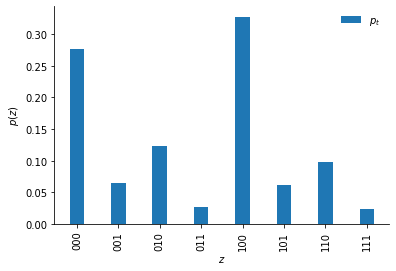

In [71]:
fig = plt.figure()
ax = fig.add_subplot()
target_plot(ax, p_target)

## Step 3: Training

The goal of the training procedure will be to minimize the [Kullback-Leibler divergence](https://en.wikipedia.org/wiki/Kullback–Leibler_divergence) between the target distribution $p_t$ and the batch-averaged sampled distribution $p_s$. In the machine-learning language the Kullback-Leibler divergence is one example of a loss-function and luckily PyTorch provides an [implementation](https://pytorch.org/docs/stable/generated/torch.nn.KLDivLoss.html). This is another good example where relying on a widely used library saves us a lot of implementation time.

In [67]:
from tqdm.notebook import trange

neurons = LIFRefracNeurons(H,N).to(device)
optim = torch.optim.Adam(neurons.parameters())
losses = []

epochs = 40 # number of epochs to optimize
pbar = trange(epochs)

for i in pbar:
  optim.zero_grad()

  # sample new poisson noise for every iteration
  z = poisson_encode(0.3 * torch.ones(B, H), T).detach().to(device)

  # compute the refractory state and voltage traces
  refrac, voltages = neurons(z)

  # the first three neurons in each batch are our readout neurons
  readout = refrac[:,:,:3]

  # compute sampled probability distribution
  p_f = three_point_correlations_func(refrac).flatten(start_dim=1)

  # batch averaged Kullback-Leibler divergence 
  loss = torch.nn.functional.kl_div(torch.log(p_f.clamp(min=1e-7)), p_target, reduction='batchmean')

  # propagate gradient to parameters through time and take optimisation step
  loss.backward()
  optim.step()

  pbar.set_postfix({"loss": loss.detach().item()})
  losses.append(loss.detach().item())


# save all the training results
basepath = "results/stochastic"
os.makedirs(basepath, exist_ok=True)
np.save(os.path.join(basepath, "refrac.npy"), refrac.detach().numpy())
np.save(os.path.join(basepath, "p_target.npy"), p_target.detach().numpy())
np.save(os.path.join(basepath, "p_f.npy"), p_f.detach().numpy())
np.save(os.path.join(basepath, "losses.npy"), np.stack(losses))
np.save(os.path.join(basepath, "voltages.npy"), voltages.detach().numpy())

## Step 4: Evaluating the Result

Every scientist knows that a great plot is more than half of the reward.


In [68]:
basepath = "results/stochastic"

refrac = torch.tensor(np.load(os.path.join(basepath, "refrac.npy")))
p_target = torch.tensor(np.load(os.path.join(basepath, "p_target.npy")))
p_f = torch.tensor(np.load(os.path.join(basepath, "p_f.npy")))
losses = torch.tensor(np.load(os.path.join(basepath, "losses.npy")))

In [69]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection, LineCollection
from matplotlib.patches import Rectangle

def negedge(z, z_prev):
  return (1-z) * z_prev

def posedge(z, z_prev):
  return z * (1 - z_prev)

mpl.rcParams['ytick.left'] = True
mpl.rcParams['ytick.labelleft'] = True
mpl.rcParams['axes.spines.left'] = True
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.bottom'] = True
mpl.rcParams['legend.frameon'] = False

def sampling_figure(ax, refrac):
  T, _, _ = refrac.shape
  N = 3

  posedges = []
  negedges = []

  z_prev = torch.zeros_like(refrac[0])
  z = refrac[0,:]


  ax.set_yticks(1.2 * np.arange(0,5) + 0.6)
  ax.set_yticklabels(['$z_1$', '$z_2$', '$z_3$', '$z_4$', '$z_5$'])
  ax.spines['left'].set_visible(False)

  for ts in range(T):
    z = refrac[ts]
    posedges.append(posedge(z, z_prev))
    negedges.append(negedge(z, z_prev))
    z_prev = z

  posedges = torch.stack(posedges)
  negedges = torch.stack(negedges)

  lines = []
  rects = []

  facecolor = "black"

  for k in range(N):
      t = posedges[200:400,0,k].to_sparse().coalesce().indices()[0]
      t_r = negedges[200:400,0,k].to_sparse().coalesce().indices()[0]


      for ts, tf in zip(t, t_r):
        rect = Rectangle((ts, k * 1.2), tf - ts, 1.0)
        line = [(ts, k*1.2), (ts, k*1.2 + 1.0)]
        rects.append(rect)
        lines.append(line)

  pc = PatchCollection(rects, facecolor=facecolor, alpha=0.2, edgecolor=None)
  lc = LineCollection(lines, color="black")

  for k in range(N):
    ax.plot(voltages[200:400,0,k].detach() + k * 1.2, label=f"$v_{k}$")


  ax.add_collection(pc)
  ax.set_ylabel("Neuron")
  ax.set_xlabel("T [ms]")
  # ax.add_collection(lc)
  ax.legend(loc="upper right", bbox_to_anchor=(1.15, 1))


def figure_stochastic_computing(p_f, p_target, losses, refrac):
  width = 0.35

  fig = plt.figure(constrained_layout=True, figsize=(7, 9))
  gs = fig.add_gridspec(nrows=3, ncols=1)

  ax_sampling = fig.add_subplot(gs[0,0])
  ax_prob = fig.add_subplot(gs[1,0])
  ax_loss = fig.add_subplot(gs[2,0])

  p_f_mean = np.mean(p_f.detach().numpy(),axis=0)
  p_f_min = np.min(p_f.detach().numpy(), axis=0)
  p_f_max = np.max(p_f.detach().numpy(), axis=0) 

  ax_sampling.text(-0.1, 1.1, "A", transform=ax_sampling.transAxes, size="medium", weight="normal")
  sampling_figure(ax_sampling, refrac)

  # plot the probabilities

  ax_prob.text(-0.1, 1.1, "B", transform=ax_prob.transAxes, size='medium', weight='normal')
  ax_prob.bar(np.arange(0,8)-width/2, p_f[0].detach().numpy(), width, label='$p_s$')
  ax_prob.bar(np.arange(0,8)+width/2, p_target[0], width, label='$p_{t}$')
  ax_prob.legend(loc='upper right')
  ax_prob.set_xticks(np.arange(0,8))
  ax_prob.set_xticklabels(['{0:03b}'.format(n) for n in np.arange(0,8)], rotation = 90)
  ax_prob.set_ylabel('$p(z)$')
  ax_prob.set_xlabel('$z$')
  ax_prob.errorbar(np.arange(0,8)-width/2, p_f_mean, yerr=[p_f_mean - p_f_min, p_f_max - p_f_mean], color='r', fmt='.k')

  ax_loss.text(-0.1, 1.1, "C", transform=ax_loss.transAxes, size='medium', weight='normal')
  ax_loss.semilogy(losses)
  ax_loss.set_ylabel('$KL(p_s | p_t)$')
  ax_loss.set_xlabel('Epoch')
  return fig

The resulting plot shows part of the neuron membrane traces of the three readout neurons, the value of the binary refractory state variables is indicated by gray shading (A). We also see how well the sampled distribution approximates the target distribution (B). Finally we plot the Kulback-Leibler divergence (C).

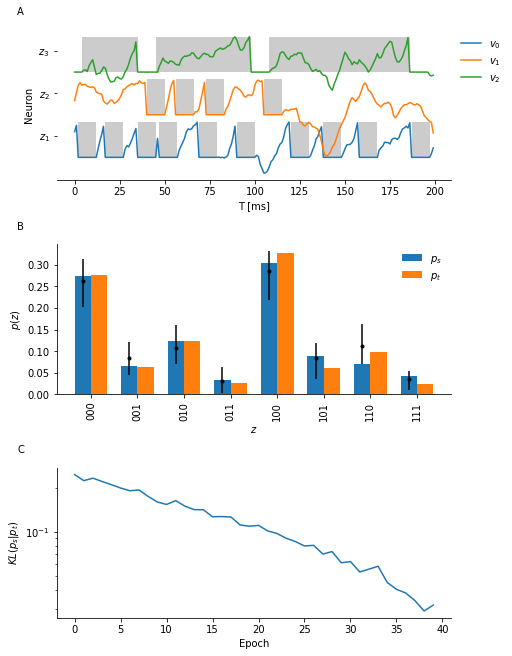

In [70]:
fig = figure_stochastic_computing(p_f, p_target, losses, refrac)
fig.savefig(os.path.join(basepath, 'stochastic_computing.png'), dpi=600, bbox_inches='tight')